# Face Mask Classification Example (part 1)
### _Adversarial Robustness_ Workshop for ODSC East Conference 
#### (scheduled for April 19th, 2022 2:00 PM EST)
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader), [Github](https://github.com/smasis001))

This notebook will walk through:



- Exploring Adversarial Evasion attacks: FGSM, Carlini-Wagner, Adversarial Patches and PGD
- Defending with Preprocessing method: Spatial Smoothing
- Defending with Adversarial Retraining: Basic Iterative Method
- Evaluating Adversarial Robustness

## The Preparations

### Installing the Libraries

In [ ]:
!pip install --upgrade numpy scikit-learn tensorflow matplotlib seaborn tqdm
!pip install --upgrade machine-learning-datasets
!pip install adversarial-robustness-toolbox==1.5.0

### Loading the Libraries

In [5]:
%%time
import math
import os
import warnings
warnings.filterwarnings("ignore")
import machine_learning_datasets as mldatasets
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
from art.attacks.evasion import CarliniLInfMethod
from art.attacks.evasion import AdversarialPatchNumpy
from art.defences.preprocessor import SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from tqdm.notebook import tqdm

The version of Tensorflow should be 2.0 or above.

In [6]:
print(tf.__version__)

2.2.0


We should also disable eager execution and verify that it worked with the following commands. The output should say that it's `False`:

In [7]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly()) 

Eager execution enabled:  False


### Understanding and Preparing the Data

We load the data into four NumPy arrays corresponding to the train/test datasets. While we are at it, we divide X face images by 255 because, that way, they will be of values between zero and one, which is better for deep learning models. 

In [8]:
X_train, X_test, y_train, y_test =\
                                    mldatasets.load("maskedface-net_thumbs_sampled", prepare=True)
X_train, X_test = X_train / 255.0, X_test / 255.0
min_ = X_train.min()
max_ = X_train.max()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/maskedface-net_thumbs_sampled.zip downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/odsc-east/odsc-east-2022/notebooks/data/maskedface-net_thumbs_sampled.zip
/Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/odsc-east/odsc-east-2022/notebooks/data/maskedface-net_thumbs_sampled.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/odsc-east/odsc-east-2022/notebooks/data/maskedface-net_thumbs_sampled
21000 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableML.ai/v2/presentations/odsc-east/odsc-east-2022/notebooks/data/maskedface-net_thumbs_sampled folder


It's always important to verify your data when you load it to make sure it didn't get corrupted. You can do this with the following code:

In [9]:
print('X_train dim:\t%s' % (X_train.shape,))
print('X_test dim:\t%s' % (X_test.shape,))
print('y_train dim:\t%s' % (y_train.shape,))
print('y_test dim:\t%s' % (y_test.shape,))
print('X_train min:\t%s' % (min_))
print('X_train max:\t%s' % (max_))
print('y_train labels:\t%s' % (np.unique(y_train)))

X_train dim:	(16800, 128, 128, 3)
X_test dim:	(4200, 128, 128, 3)
y_train dim:	(16800, 1)
y_test dim:	(4200, 1)
X_train min:	0.0
X_train max:	1.0
y_train labels:	['Correct' 'Incorrect' 'None']


The images have dimensions of 128 × 128 pixels and three channels (color). There are 16,800 training images and 4,200 test images. The labels only have a one in the second value, which indicates that it's not one-hot encoded. Indeed, by printing the unique values (`np. unique(y_train)`), you can tell that the labels are represented as text—`Correct` for correctly masked, `Incorrect` for incorrectly masked, and `None` for no mask.

A preprocessing step we will need to perform is to one-hot encode (OHE) the y labels because we will need the OHE form to evaluate the model's predictive performance.

In [10]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
labels_l = ohe.categories_[0].tolist()
print(labels_l)

['Correct', 'Incorrect', 'None']


For reproducibility's sake, always initialize your random seeds like this:

In [11]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

Granted, determinism is very difficult with deep learning and often is session-, platform-, and architecture-dependent. 

Many of the adversarial attack, defense, and evaluation methods we will study in this chapter are very resource-intensive. For efficiency, it is strongly suggested to use samples of the test dataset. Therefore, we will create a medium 200-image sample (X_test_mdsample, y_test_mdsample) and a small 20-image sample (X_test_ smsample, y_test_smsample) using np.random.choice. The code is shown in the following snippet:

In [12]:
sampl_md_idxs = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_mdsample = X_test[sampl_md_idxs]
y_test_mdsample = y_test[sampl_md_idxs]
sampl_sm_idxs = np.random.choice(X_test.shape[0], 20, replace=False)
X_test_smsample = X_test[sampl_sm_idxs]
y_test_smsample = y_test[sampl_sm_idxs]

Now, let's take a peek at the images in our datasets:

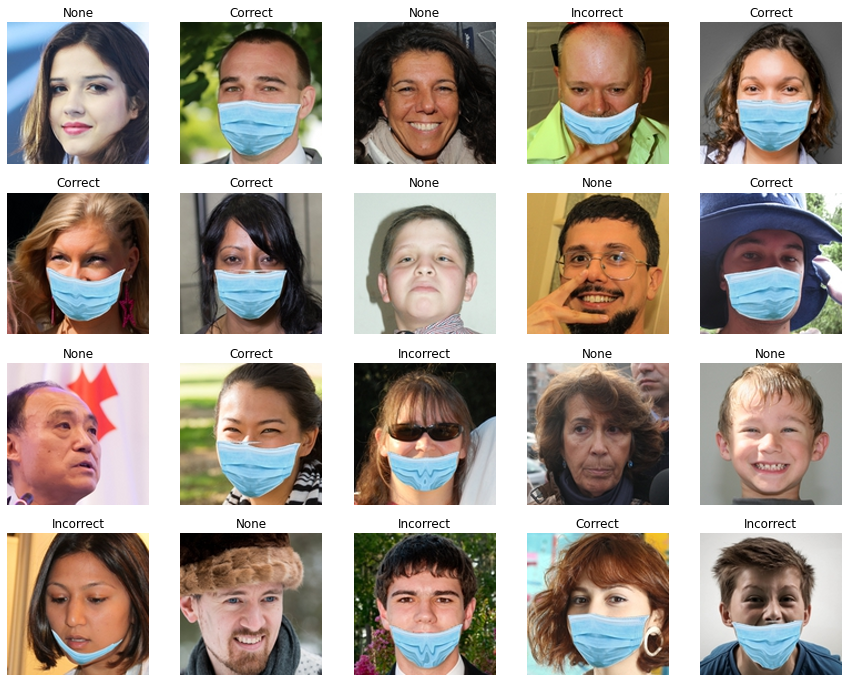

In [13]:
plt.subplots(figsize=(15,12))
for s in range(20):
    plt.subplot(4, 5, s+1)
    plt.title(y_test_smsample[s][0], fontsize=12)
    plt.imshow(X_test_smsample[s], interpolation='spline16')
    plt.axis('off')
plt.show()

### Training the CNN Base Model
***Optional: takes 5-25 minutes***

We won't do this in this session but you can use this for reference and do it in your spare time.

In [ ]:
%%time
base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(768, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Base_MaskedFaceNet_Model')

base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

In [ ]:
%%time
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,\
                                patience=3, restore_best_weights=True) 

base_model.fit(X_train, ohe.transform(y_train), validation_split=0.2,\
               batch_size=128, callbacks=[es], epochs=30, verbose=1)

_, accuracy_test = base_model.evaluate(X_test, ohe.transform(y_test))
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

### Loading the CNN Base Model

Let's load a pretrained model from a repository and print the model summary. 

In [14]:
%%time
model_path = get_file('CNN_Base_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Base_MaskedFace_Net.hdf5?raw=true')
base_model = tf.keras.models.load_model(model_path)
base_model.summary()

43737088/43734584 [==============================] - 1s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CNN_Base_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool2d_3 (MaxPooling2

The summary has pretty much everything we need to know about the model. It has four convolutional layers (Conv2D), each followed by a max pool layer (MaxPooling2D). It then has a Flatten layer and a fully connected layer (Dense). Then, there's more Dropout before the second Dense layer. Naturally, three neurons are in this final layer, corresponding to each class.

### Assessing the CNN Base Classifier

We can evaluate the model using the test dataset with the `evaluate_multiclass_mdl` function. The arguments include the model (`base_model`), our test data (`X_test`), and corresponding labels (`y_test`), as well as the class names (`labels_l`) and the encoder (`ohe`).

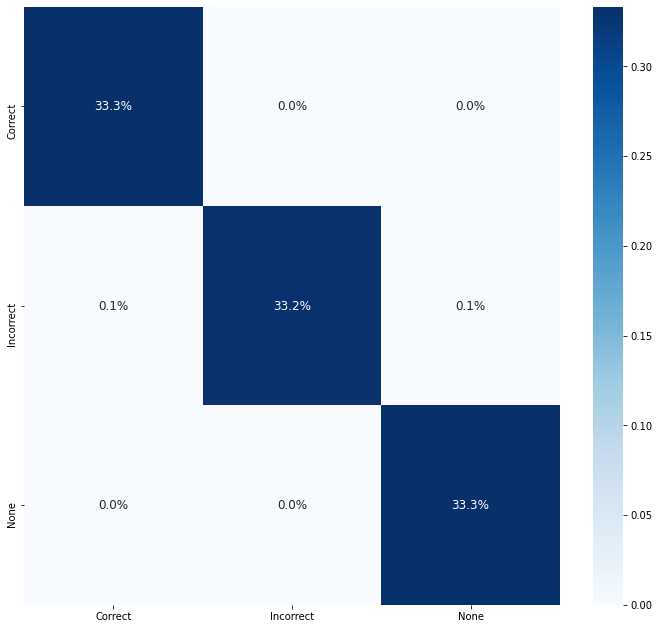

              precision    recall  f1-score   support

     Correct      0.998     0.998     0.998      1400
   Incorrect      0.999     0.995     0.997      1400
        None      0.996     0.999     0.998      1400

    accuracy                          0.997      4200
   macro avg      0.997     0.997     0.997      4200
weighted avg      0.997     0.997     0.997      4200



In [15]:
y_test_pred, y_test_prob = mldatasets.evaluate_multiclass_mdl(base_model, X_test, y_test, labels_l, ohe,\
                                                    plot_conf_matrix=True, predopts={"verbose":1})

Even though the confusion matrix seems to suggest a perfect classification, you can tell that the model had issues with misclassifying as incorrectly masked once you see the precision-and-recall breakdown.

## Learning about Evasion Attacks

The `ART` library requires that attacked models are abstracted in an estimator or classifier, even if it's a black-box one. We will use `KerasClassifier` for most of this exercise except for the 2nd part, in which we
use `TensorFlowV2Classifier`. Initializing an `ART` classifier is fairly simple. You must specify the model attribute, and sometimes there are other required attributes. For `KerasClassifier` all remaining attributes are optional, but it is recommended you use `clip_values` to specify the range of the features. Many attacks are input permutations, so knowing which input values are allowed or feasible is essential.

In [16]:
%%time
base_classifier = KerasClassifier(model=base_model, clip_values=(min_, max_))
y_test_mdsample_prob = np.max(y_test_prob[sampl_md_idxs], axis=1)
y_test_smsample_prob = np.max(y_test_prob[sampl_sm_idxs], axis=1)

### Fast Gradient Sign Method Attack

One of the most popular attack methods is the Fast Gradient Sign Method (also known as FGSM or FGM). As the name implies, this leverages a deep learning model's gradient to find adversarial examples. It performs small perturbations on the pixels of the input image, either additions or subtractions, and which one to use depends on the gradient's sign, which indicates the direction in which the loss would increase or decrease, according to the pixel's intensity. 

`FastGradientMethod` requires an eps attack step size, which will condition the attack strength. A low step size will cause pixel-intensity changes to be less visible, but it will also misclassify fewer examples. A larger step size will cause more examples to be misclassified, with more visible changes.

In [17]:
%%time
attack_fgsm = FastGradientMethod(base_classifier, eps=0.1)

After initializing, the next step is to generate the adversarial examples. The only required attribute is original examples (`X_test_mdsample`)

In [18]:
%%time
X_test_fgsm = attack_fgsm.generate(X_test_mdsample)

Generating the adversarial examples with FGSM is quick, unlike other methods, hence the
"Fast" in the name!

Now, we are going to do two things in one swoop. First, we'll evaluate the adversarial
examples (`X_test_fgs`m) against our base classifier's model (`base_classifier.model`) with `evaluate_multiclass_mdl`. Then, we can employ `compare_image_predictions` to plot a grid of images, contrasting the randomly selected adversarial examples (from `X_test_fgsm`) against the original ones (`X_test_mdsample`), and their corresponding predicted labels (`y_test_fgsm_pred`, `y_test_mdsample`) and probabilities (`y_test_fgsm_prob`, `y_test_mdsample_prob`). We are customizing the titles and limiting the grid to 4 examples (`num_samples`). By default, `compare_ image_predictions` only compares misclassifications, but the `use_misclass` optional attribute can be set to false to compare correct classifications.

In [ ]:
%%time
y_test_fgsm_pred, y_test_fgsm_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_fgsm, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_prob = np.max(y_test_fgsm_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.056     0.014     0.023        70
   Incorrect      0.220     0.370     0.276        54
        None      0.736     0.882     0.802        76

    accuracy                          0.440       200
   macro avg      0.337     0.422     0.367       200
weighted avg      0.359     0.440     0.387       200



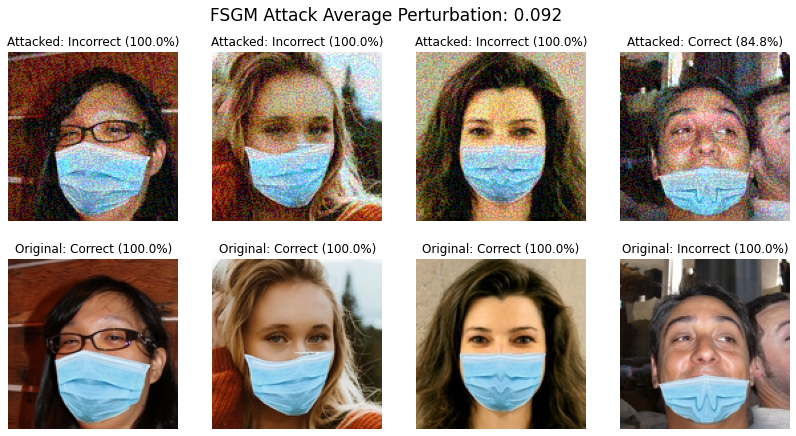

In [19]:
%%time
mldatasets.compare_image_predictions(X_test_fgsm, X_test_mdsample, y_test_fgsm_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

The perturbations are on average a 9.2% shift in the values for pixels. And even though it wasn't a targeted attack, if perpetrators managed to cause this level of signal distortion or interference, they would severely undermine the security company's ability to monitor mask compliance sin it cuts performance drastically.

### Carlini & Wagner Infinity-norm Attack

What if you wanted to be the least detectable yet still cause enough damage to make the system useful. Then, Carlini & Wagner’s Infinity Norm is the way to go. C&W employs a gradient-descent-based optimization algorithm with three norm-based distance metrics:  $L_0$, $L_2$ and $L_{\infty}$)  measuring the differences between the original and adversarial example. $L_{\infty}$ is arguable the best one because you make sure that the adversarial example is not just "on average" minimally different but not too different anywhere in the feature space. That is, no pixel is more different than it should be to provoke a misclassification.

$L_{\infty} = ||x − x'||_{\infty} = max(|x_1 − x'_1|, . . . , |x_n − x'_n|)$

Initializing C&W infinity-norm attacks and generating adversarial examples with it is similar to FGSM. To initialize `CarliniLInfMethod`, we define an `eps` and, optionally, a `batch_size` (default is 128). Then, to generate an untargeted adversarial attack, the same applies as with FGSM—Only `X` is needed when untargeted, but `y` is needed when targeted.

In [20]:
%%time
attack_cw = CarliniLInfMethod(base_classifier, eps=0.3, batch_size=40)
X_test_cw = attack_cw.generate(X_test_mdsample)

C&W L_inf: 100%|██████████| 5/5 [02:28<00:00, 29.65s/it]


We will now evaluate the C&W adversarial examples (`X_test_cw`), just as we did with FGSM. It's exactly the same code but with `fsgm` replaced with `cw`, and different titles in `compare_image_predictions`.

In [ ]:
%%time
y_test_cw_pred, y_test_cw_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_cw, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_cw_prob = np.max(y_test_cw_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.932     0.971     0.951        70
   Incorrect      0.839     0.963     0.897        54
        None      0.985     0.842     0.908        76

    accuracy                          0.920       200
   macro avg      0.918     0.925     0.918       200
weighted avg      0.927     0.920     0.920       200



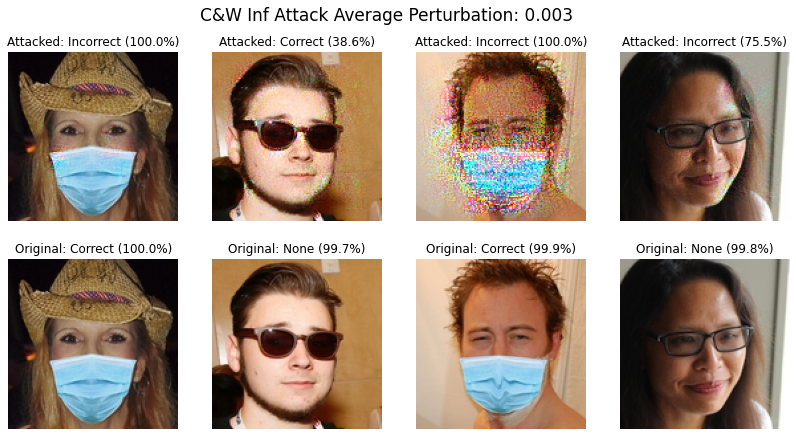

In [21]:
%%time
mldatasets.compare_image_predictions(X_test_cw, X_test_mdsample, y_test_cw_pred,\
                                     y_test_mdsample.flatten(), y_test_cw_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="C&W Inf Attack Average Perturbation: ",\
                                     num_samples=4)

In this case, the “incorrect” class is the low hanging fruit because it only takes a few pixels to make correct look like incorrect or none like incorrect. For this reason, the average perturbation is barely detectable and it has exploited the vulnerabilities with the “incorrect” class. 

### Targeted Adversarial Patch Attack

However, if you are not trying to be stealth the easiest way is to employ a patch. AP is a robust, universal, and targeted method. You generate a patch that you can either superimpose on an image or print and physically place in a scene, to trick a classifier into ignoring everything else in the scene. It is designed to work under a wide variety of conditions and transformations. There's no intention of camouflaging the attack because, essentially, you are replacing a detectable portion of the scene with the patch. The method works by leveraging a variant of Expectation over Transformation (EOT), which trains images over transformations of a given patch on different locations of an image.

We will use `AdversarialPatchNumpy`, which is a variant that works with any CNN classifier. There's also one for TensorFlow v2, but our base classifier is `KerasClassifier`. The first argument is the classifier (`base_ classifier`), and the other ones we will define are optional but highly recommended. The `scale_min` and `scale_max` scaling ranges are particularly important because they define how big patches can be in relation to the images—in this case, we want to test no smaller than 40% and no larger than 70%. Besides that, it makes sense to define a target class (`target`). In this case, we want the patch to target the "Correct" class. For the `learning_rate` and max iterations (`max_iter`) we are using the defaults, but note that these can be tuned to improve patch adversarial effectiveness.

In [22]:
%%time
attack_ap = AdversarialPatchNumpy(base_classifier, scale_min=0.4, scale_max=0.7,\
                                  learning_rate=5., max_iter=500, batch_size=40,\
                                  target=0)


We don't want the patch-generation algorithm to waste time testing patches everywhere in images, so we can direct this effort by using a Boolean mask. This mask tells it where it can center the patch. To make the mask, we start by creating an array of 0s of size 128 × 128. Then, we place 1s in the rectangular area between pixels 80-93 and 45-84, which loosely corresponds to covering the center of the mouth area in most of the images. Lastly, we expand the array's dimensions so that it's (1, W, H) and convert it to boolean. Then, we can proceed to generate patches using the small-size test dataset samples and the mask.

In [23]:
%%time
placement_mask = np.zeros((128,128))
placement_mask[80:93,45:83] = 1
placement_mask = np.expand_dims(placement_mask, axis=0).astype(bool)

patch, patch_mask = attack_ap.generate(x=X_test_smsample,\
                                       y=ohe.transform(y_test_smsample),\
                                       mask=placement_mask)

Adversarial Patch Numpy: 100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


We can now plot the patch with the following code:

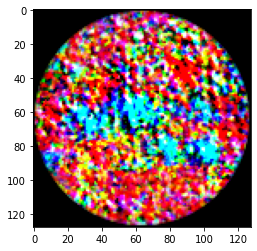

In [24]:
plt.imshow(patch * patch_mask)
plt.show()

As expected, it has plenty of shades of blue found in masks. It also has bright red and yellow hues, mostly missing from training examples, which confuses the classifier.

Unlike other methods, generate didn't produce adversarial examples but a single patch, which is an image we can then place on top of images to create adversarial examples. This task is performed with `apply_patch`, which takes the original `X_test_smsample` examples and a scale—we are using 55%. It is also recommended to use a mask, which will make sure the patch is applied where it makes more sense—in this case, in the area around the mouth. Note that targeted attacks, in general, need more examples to understand how to best target one class, but we are using the small dataset because it can otherwise be resource intensive.

In [25]:
%%time
X_test_ap = attack_ap.apply_patch(X_test_smsample, scale=0.55, mask=placement_mask)

Now, it's time to evaluate our attack and examine some misclassifications. We will do exactly as before, reusing the code from previous attacks.

In [ ]:
%%time
y_test_ap_pred, y_test_ap_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_ap, y_test_smsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_ap_prob = np.max(y_test_ap_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000         7
   Incorrect      0.250     1.000     0.400         5
        None      0.000     0.000     0.000         8

    accuracy                          0.250        20
   macro avg      0.083     0.333     0.133        20
weighted avg      0.062     0.250     0.100        20



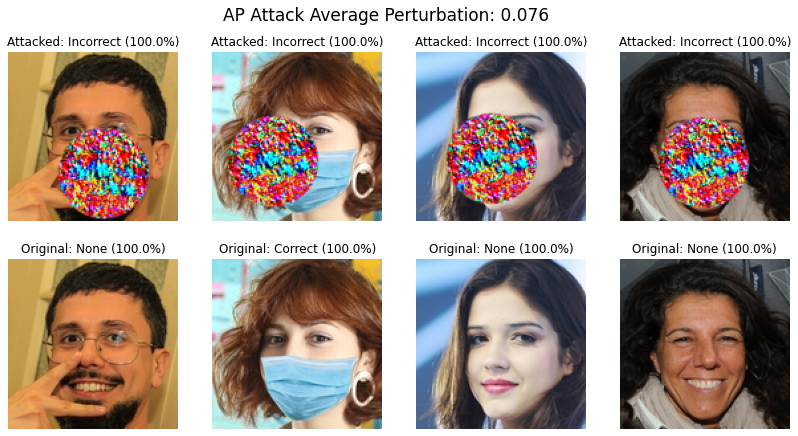

In [26]:
%%time
mldatasets.compare_image_predictions(X_test_ap, X_test_smsample, y_test_ap_pred,\
                                     y_test_smsample.flatten(), y_test_ap_prob,\
                                     y_test_smsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="AP Attack Average Perturbation: ",\
                                     num_samples=4)

The perturbations are on average a 8.0% shift in the values for pixels, and it causes quite an impact in the model.

## Defending Against Targeted Attacks with Preprocessing

Now we are going to explore how to defend with preprocessing. 

That is, changing a model's inputs so that they are harder to attack.

But first we have to create inputs that have been already attacked. And to make sure it's brutally effective we will use a targetted attack — and, worse, one that is strong.

To create a targeted attack against the correctly masked class, it's best that we only select examples that aren't correctly masked (`y_test_notmaske`d), with their corresponding labels (`y_test_notmasked`) and predicted probabilities (`y_test_notmasked_prob`). Then, we want to create an array with the class ("Correct") for which we want to generate adversarial examples (`y_test_masked`).

In [27]:
%%time
not_masked_idxs = np.where(y_test_smsample != 'Correct')[0]
X_test_notmasked = X_test_smsample[not_masked_idxs]
y_test_notmasked = y_test_smsample[not_masked_idxs]
y_test_notmasked_prob = y_test_smsample_prob[not_masked_idxs]
y_test_masked = np.array(['Correct'] * X_test_notmasked.shape[0]).reshape(-1,1)

### Attack with Projected Gradient Descent (PGD) 

The worse evasion attack you probably could inflict is Projected Gradient Descent. It’s a strong attack very similar in output to FGSM—that is, it produces noisy images. It’s also a first-order adversary because it leverages first-order information about a network (due to gradient descent). Also, PGD in experiments proves that robustness against PGD ensures robustness against any first-order adversary. Precisely, PGD is a strong attack, so it makes for conclusive benchmarks. We don’t expect our adversary to have access to the model but if we prove robustness even against PGD we are in good shape for black-box attacks.

We initialize `ProjectedGradientDescent` as we did FGSM, except we are going to set the maximum perturbation (`eps`), attack step size (`eps_step`), maximum iterations (`max_iter`), and `targeted=True`. Precisely because it is targeted, we are going to set both `X` and `y`.

In [28]:
%%time
attack_pgd = ProjectedGradientDescent(base_classifier, eps=0.3, eps_step=0.01, max_iter=40,\
                                      targeted=True)
X_test_pgd = attack_pgd.generate(X_test_notmasked,\
                                 y=ohe.transform(y_test_masked))

PGD - Random Initializations: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


Now, let's evaluate the PGD attack as we have done before, but this time let's plot the
confusion matrix (`plot_conf_matrix=True`), as follows:

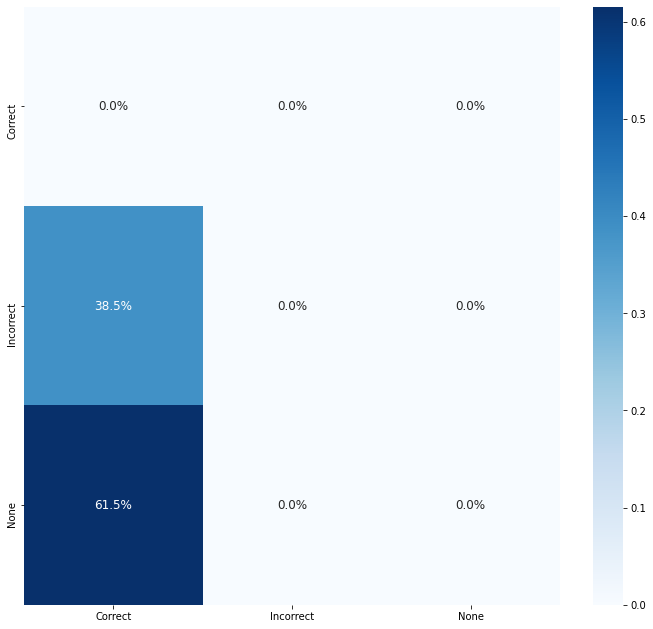

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000       0.0
   Incorrect      0.000     0.000     0.000       5.0
        None      0.000     0.000     0.000       8.0

    accuracy                          0.000      13.0
   macro avg      0.000     0.000     0.000      13.0
weighted avg      0.000     0.000     0.000      13.0



In [29]:
%%time
y_test_pgd_pred, y_test_pgd_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=True, plot_roc=False)
y_test_pgd_prob = np.max(y_test_pgd_prob, axis=1)

The PGD attack was so effective that it produced an accuracy rate of 0%, making all unmasked and incorrectly masked examples appear to be masked. Now, let's show a grid with the image comparisons.

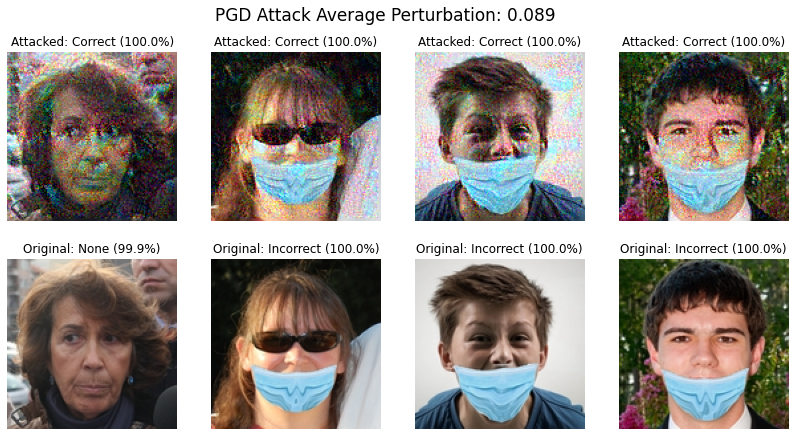

In [30]:
%%time
mldatasets.compare_image_predictions(X_test_pgd, X_test_notmasked, y_test_pgd_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_prob, y_test_smsample_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ")

The mean absolute perturbation is among the highest we've seen so far, and all unmasked faces in the grid are classified as correctly masked (as expected).

### Defend with Spatial Smoothing

What is the simplest way to combat noise?

Anyone that has worked with Photoshop might know the answer to this question.

> Blur

And "spatial smoothing" is just a fancy way of saying blur! However, what's novel about it being introduced as an adversarial defence method is that the proposed implementation (`SpatialSmoothing`) calls for using the median and not the mean in a sliding window. The window size value is configurable, and it is recommended to adjust it where it is most useful as a defense. Here, we are using a `window_size=11`. Once the defence has been initialized, you plug in the adversarial examples (`X_test_pgd`). This will output spatially smoothed adversarial examples (`X_ test_pgd_ss`).

In [31]:
%%time
defence_ss = SpatialSmoothing(window_size=11)
X_test_pgd_ss, _ = defence_ss(X_test_pgd)

Now, we can take the blurred adversarial examples produced and evaluate them as we did before, first with evaluate_multiclass_mdl to get predicted labels (`y_test_pgd_ ss_pred`) and probabilities (`y_test_pgd_ss_prob`), as well as the output of some predictive performance metrics. 

In [32]:
%%time
y_test_pgd_ss_pred, y_test_pgd_ss_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd_ss, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_pgd_ss_prob = np.max(y_test_pgd_ss_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000         0
   Incorrect      1.000     0.600     0.750         5
        None      0.750     0.375     0.500         8

    accuracy                          0.462        13
   macro avg      0.583     0.325     0.417        13
weighted avg      0.846     0.462     0.596        13



As you can see here, it took a model that was at 0% accuracy once attacked by the very aggressive PGD and it pushed it up to over 40% simply by blurring images before model inference. By adjusting the `window_size` of the defense it can likely be improved.

With `compare_image_predictions` to plot a grid of images, let's use `use_misclass=False` to compare properly classified images — in other words, the adversarial examples that were defended successfully.

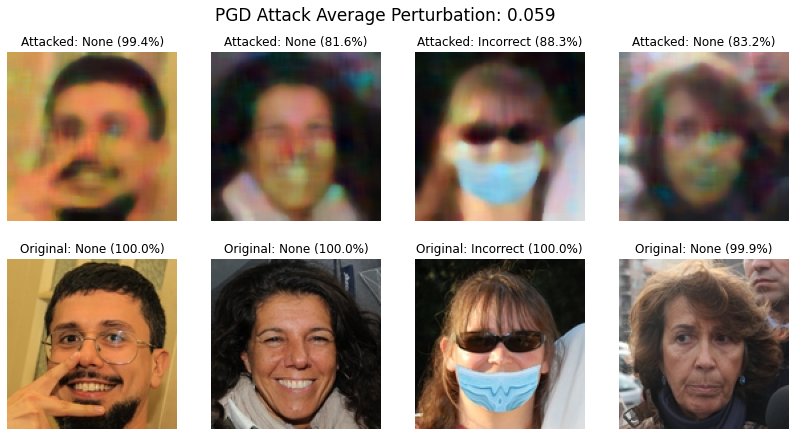

In [33]:
%%time
mldatasets.compare_image_predictions(X_test_pgd_ss, X_test_notmasked, y_test_pgd_ss_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_ss_prob, y_test_notmasked_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ",\
                                     use_misclass=False)

## Shielding Against Any Evasion Attack by Adversarial Training of a Robust Classifier

Another better defense can be implement during training. If you augment the data to include plausible examples of adversarial attacks, the model will learn to classify them. _In a nutshell_: that's what adversarial training is although there are a few variants. For model robustness, training data variety is critical, but only if it represents the intended environment. In statistical terms, it's a question of using samples for training that accurately depict the population so that the model learns to classify them correctly. For adversarial robustness, the same principles apply. This form of defense as very effective to any kind of evasion attack, essentially shielding it.

### Training the CNN Robust Model
***Optional: takes anywhere between 1-15 hrs***

That being said, it's not impervious. Its effectiveness is contingent on using the right kind of adversarial examples in training and using the optimal hyperparameters, and so forth. There are some guidelines outlined by researchers, such as increasing the number of neurons in the hidden layers, and using PGD or the `BasicIterativeMethod` (BIM) method to produce adversarial examples for the training. BIM is like FGSM but not as fast, because it iterates to approximate the best adversarial example within a eps-neighborhood for the original image. The `eps` attribute bounds this neighborhood.

In [ ]:
%%time
robust_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Robust_MaskedFaceNet_Model')

robust_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

robust_model.summary()

Next, we can adversarially train the model by first initializing a new `KerasClassifier`
classifier with the `robust_model`. Then, we initialize a `BasicIterativeMethod`
attack on this classifier. Lastly, we initialize `AdversarialTrainer` with `robust_classifier` and the BIM attack, and fit it. Please note that we saved the BIM attack into a variable called `attacks` because this could be a list of ART attacks instead of a single one. Also, note that `AdversarialTrainer` has an attribute called `ratio`. This
attribute determines what percentage of the training examples are adversarial examples. This percentage dramatically impacts the effectiveness of adversarial attacks. If it's too low, it might not perform well with adversarial examples and, if it's too high, it might perform less effectively with non-adversarial examples. If you run the trainer, it will likely take many hours to complete, so don't get alarmed.

In [ ]:
%%time
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=20)
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=0.5)
trainer.fit(X_train, ohe.transform(y_train), nb_epochs=30, batch_size=128)

### Loading the CNN Robust Model

If you didn't train the `robust_classifier`, we can download a pre-trained `robust_model` and initialize the robust_classifier with it, like this:

In [34]:
%%time
model_path = get_file('CNN_Robust_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Robust_MaskedFace_Net.hdf5?raw=true')
robust_model = tf.keras.models.load_model(model_path)
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))

43024384/43019888 [==============================] - 1s 0us/step


### Assessing the CNN Robust Classifier

Now, let's evaluate the robust_classifier against the original test dataset, using `evaluate_multiclass_mdl`. We set `plot_conf_matrix=True` to see the confusion matrix, as follows:

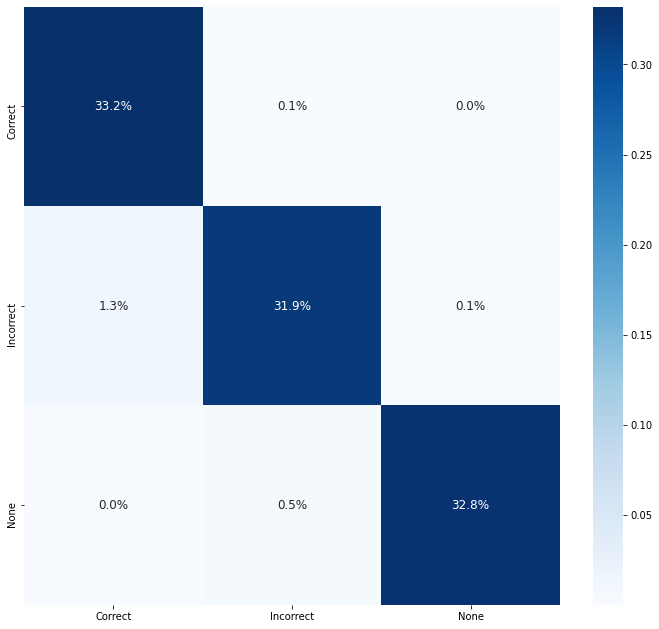

              precision    recall  f1-score   support

     Correct      0.962     0.996     0.979      1400
   Incorrect      0.980     0.957     0.969      1400
        None      0.994     0.983     0.989      1400

    accuracy                          0.979      4200
   macro avg      0.979     0.979     0.979      4200
weighted avg      0.979     0.979     0.979      4200



In [35]:
y_test_robust_pred, y_test_robust_prob =\
                mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test, y_test,\
                                                   labels_l, ohe, plot_conf_matrix=True,\
                                                   predopts={"verbose":1})

It's 1.8% less accurate than the base classifier. Most of the misclassifications are with correctly masked faces getting classified as incorrectly masked. There's certainly a trade-off when choosing a 50% adversarial example ratio, or perhaps we can do some tuning to the hyperparameters or the model architecture to improve this.

#### Attacking with FGSM

Let's see how the robust model fares against adversarial attacks. Let's use the `FastGradientMethod` again, but this time replace `base_classifier` with `robust_classifier`, as follows:

In [36]:
%%time
attack_fgsm_robust = FastGradientMethod(robust_classifier, eps=0.1)
X_test_fgsm_robust = attack_fgsm_robust.generate(X_test_mdsample)

#### Evaluate Robust CNN against attacked samples

Next, we can employ `evaluate_multiclass_mdl` and `compare_image_predictions` to measure and observe the effectiveness of our attack, but this time against the robust_classifier, as follows:

In [ ]:
%%time
y_test_fgsm_robust_pred, y_test_fgsm_robust_prob =\
    mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test_fgsm_robust, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_robust_prob = np.max(y_test_fgsm_robust_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.921     1.000     0.959        70
   Incorrect      0.942     0.907     0.925        54
        None      1.000     0.947     0.973        76

    accuracy                          0.955       200
   macro avg      0.954     0.952     0.952       200
weighted avg      0.957     0.955     0.955       200



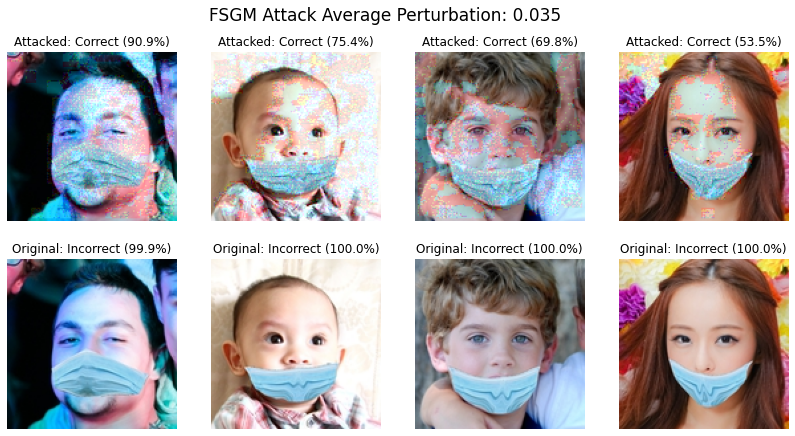

In [37]:
%%time
mldatasets.compare_image_predictions(X_test_fgsm_robust, X_test_mdsample, y_test_fgsm_robust_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_robust_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

The output evidenced an accuracy rate of 95.5%. If you compare how an equally strengthened FGSM attack fared against the `base_classifier`, it yielded 44% accuracy. That was quite an improvement! You can tell how the FGSM attack against the robust model makes less grainy and more patchy images. On average, they are overall less perturbed than they were against the base model because so few of them were successful, but those that were, were significantly degraded. Of course, an evasion attack can't actually do that, but what happened was the FGSM algorithm converged at the same shades of blue, brown, red, and orange as ones that could fool the classifier! Other shades remain unaltered.

## Evaluating and Certifying Adversarial Robustness

Would Hyundai not crash test it’s cars? Would Airbus not fatigue test it’s plane wings?

It's necessary to test your systems in any engineering endeavor to see how vulnerable they are to attacks or accidental failures.

However, security is a domain where you must stress-test your system to ascertain what level of attack is needed to make your system break down beyond an acceptable threshold. Furthermore, figuring out what level of defense is needed to curtail an attack is useful information too.


### Comparing Model Robustness with Attack Strength

Now have two classifiers we can compare against an equally strengthed attack, and we can try different attack strengths to see how they fare across all of them. We will use FGSM because it's fast, but you could use any method!

The first attack strength we can assess is "no attack strength". In other words, what is the classification accuracy against the test dataset with no attack? We had already stored the predicted labels for both the base (`y_test_pred`) and robust (`y_test_robust_ pred`) models, so this is easy to obtain with the accuracy_score metric from scikit-learn, as illustrated in the following code snippet:

In [38]:
accuracy_base_0 = metrics.accuracy_score(y_test, y_test_pred)
accuracy_robust_0 = metrics.accuracy_score(y_test, y_test_robust_pred)

We can now iterate across a range of attack strengths (`eps_range`) between 0.01 and 0.9. Using linspace, we can generate 9 values between 0.01 and 0.09 and 9 values between 0.1 and 0.9, and concatenate them into a single array. 

In [ ]:
eps_range = np.concatenate((np.linspace(0.01, 0.09, 9),\
                            np.linspace(0.1, 0.9, 9)), axis=0).tolist()

We will test attacks for these 18 eps values by for looping through all of them, and then attacking each model and retrieving the post-attack accuracies with evaluate. The respective accuracies are appended to two lists (accuracy_base and accuracy_robust), and after the for loop, we prepend zero to `eps_range` to account for the accuracies prior to any attacks, as illustrated in the following code snippet:

In [39]:
%%time
accuracy_base = [accuracy_base_0]
accuracy_robust = [accuracy_robust_0]
for eps in tqdm(eps_range, desc='EPS'):
    attack_fgsm.set_params(**{'eps': eps})
    X_test_fgsm_base_i = attack_fgsm.generate(X_test_mdsample)
    _, accuracy_base_i = base_classifier.model.evaluate(X_test_fgsm_base_i,\
                                            ohe.transform(y_test_mdsample))
    
    attack_fgsm_robust.set_params(**{'eps': eps})
    X_test_fgsm_robust_i = attack_fgsm_robust.generate(X_test_mdsample)
    _, accuracy_robust_i = robust_classifier.model.evaluate(X_test_fgsm_robust_i,\
                                            ohe.transform(y_test_mdsample))
    
    accuracy_base.append(accuracy_base_i)
    accuracy_robust.append(accuracy_robust_i)
    
eps_range = [0] + eps_range

EPS:   0%|          | 0/18 [00:00<?, ?it/s]

CPU times: user 5min 27s, sys: 58.8 s, total: 6min 26s
Wall time: 2min 8s


Now, we can plot the accuracies for both classifiers across all attack strengths with the following code:

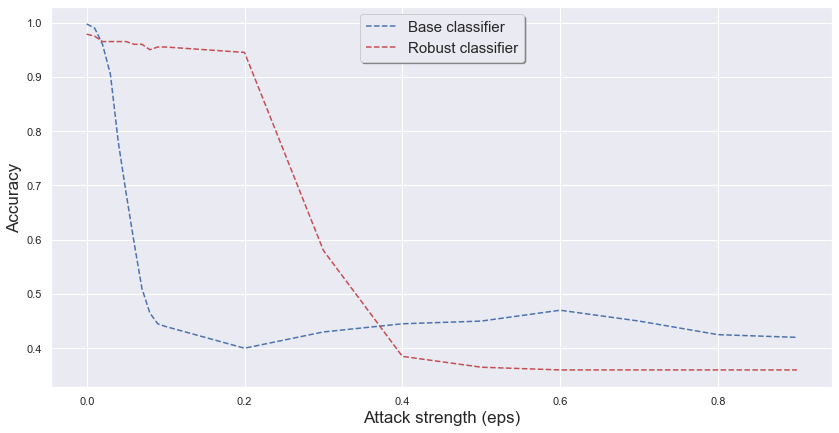

In [40]:
sns.set()
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.array(eps_range), np.array(accuracy_base), 'b--', label='Base classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')
legend = ax.legend(loc='upper center', shadow=True, fontsize=15)
plt.xlabel('Attack strength (eps)', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.show()

The above plot demonstrates that the robust model performs better between attack strengths of 0.02 and 0.35 but then consistently does about 10% worse.